In [1]:

%pprint
%matplotlib inline
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')
from jobpostlib import (crf, cu, datetime, duration, hau, hc, humanize, ihu, lru, nu, osp, scrfcu, slrcu, ssgdcu, su, t0, time, wsu, speech_engine)
from pandas import DataFrame
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
import matplotlib.dates as mdates

Pretty printing has been turned OFF
======== Neo4j/4.4.7 ========
Utility libraries created in 9 seconds


In [2]:

# Cypher for job hunting activity since the beginning of recorded history
cypher_str = '''
    // Count job hunting activity since the beginning of recorded history
    CALL {
        
        MATCH (fn:FileNames)
        WHERE (fn.tech_interview_completion_date <= date())
        RETURN
            fn.tech_interview_completion_date AS action_date,
            0 AS application_count,
            0 AS rejection_count,
            0 AS screen_count,
            COUNT(fn.tech_interview_completion_date) AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE (fn.recruiter_screen_completion_date <= date())
        RETURN
            fn.recruiter_screen_completion_date AS action_date,
            0 AS application_count,
            0 AS rejection_count,
            COUNT(fn.recruiter_screen_completion_date) AS screen_count,
            0 AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE (fn.rejection_email_date <= date())
        RETURN
            fn.rejection_email_date AS action_date,
            0 AS application_count,
            COUNT(fn.rejection_email_date) AS rejection_count,
            0 AS screen_count,
            0 AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE (fn.opportunity_application_email_date <= date())
        RETURN
            fn.opportunity_application_email_date AS action_date,
            COUNT(fn.opportunity_application_email_date) AS application_count,
            0 AS rejection_count,
            0 AS screen_count,
            0 AS interview_count
    
    }
    WITH action_date, SUM(application_count) AS total_applications, SUM(rejection_count) AS total_rejections, SUM(screen_count) AS total_screens, SUM(interview_count) AS total_interviews
    RETURN
        action_date,
        total_applications,
        total_rejections,
        total_screens,
        total_interviews
    ORDER BY action_date ASC;'''

In [18]:

# Cypher for job hunting activity since last day of work
cypher_str = '''
    // Count job hunting activity since last day of work
    CALL {
        
        MATCH (fn:FileNames)
        WHERE ((fn.tech_interview_completion_date <= date()) AND (fn.tech_interview_completion_date >= date("2024-06-13")))
        RETURN
            fn.tech_interview_completion_date AS action_date,
            0 AS application_count,
            0 AS rejection_count,
            0 AS screen_count,
            COUNT(fn.tech_interview_completion_date) AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE ((fn.recruiter_screen_completion_date <= date()) AND (fn.recruiter_screen_completion_date >= date("2024-06-13")))
        RETURN
            fn.recruiter_screen_completion_date AS action_date,
            0 AS application_count,
            0 AS rejection_count,
            COUNT(fn.recruiter_screen_completion_date) AS screen_count,
            0 AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE ((fn.rejection_email_date <= date()) AND (fn.rejection_email_date >= date("2024-06-13")))
        RETURN
            fn.rejection_email_date AS action_date,
            0 AS application_count,
            COUNT(fn.rejection_email_date) AS rejection_count,
            0 AS screen_count,
            0 AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE ((fn.opportunity_application_email_date <= date()) AND (fn.opportunity_application_email_date >= date("2024-06-13")))
        RETURN
            fn.opportunity_application_email_date AS action_date,
            COUNT(fn.opportunity_application_email_date) AS application_count,
            0 AS rejection_count,
            0 AS screen_count,
            0 AS interview_count
    
    }
    WITH action_date, SUM(application_count) AS total_applications, SUM(rejection_count) AS total_rejections, SUM(screen_count) AS total_screens, SUM(interview_count) AS total_interviews
    RETURN
        action_date,
        total_applications,
        total_rejections,
        total_screens,
        total_interviews
    ORDER BY action_date ASC;'''

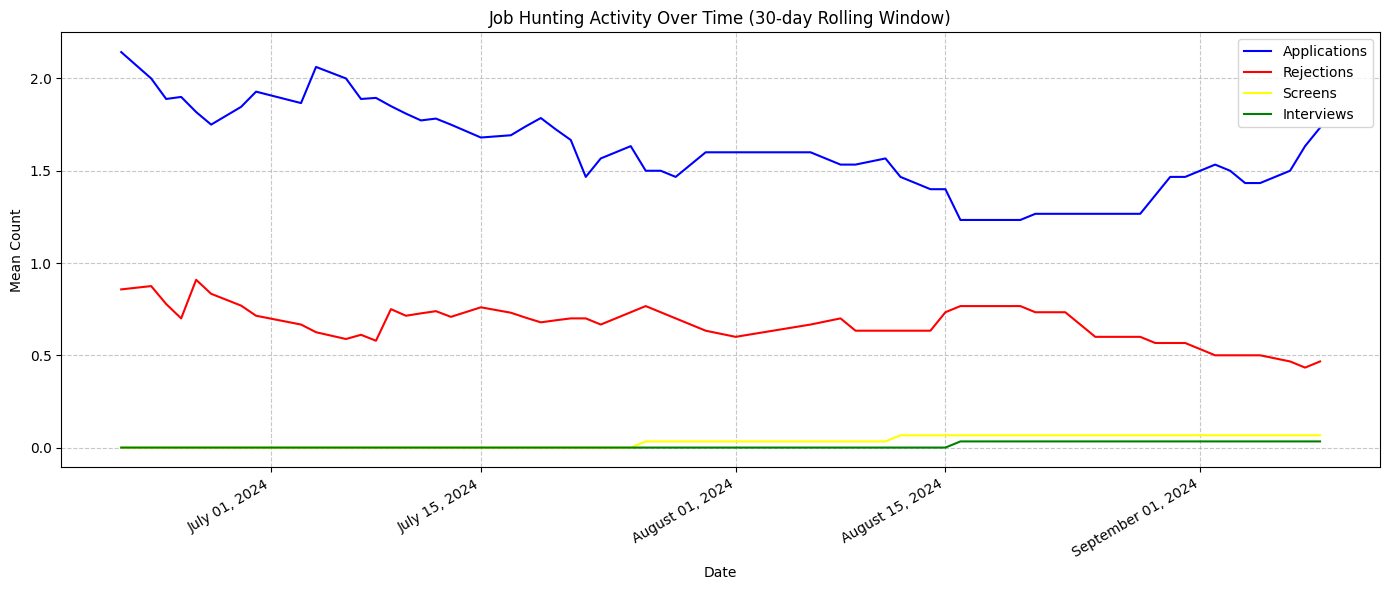

In [19]:

# Count job hunting activity since last day of work
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    df = DataFrame(row_objs_list).set_index('action_date')
    
    # Convert neo4j.time.Date to Python date
    df.index = [date(d.year, d.month, d.day) for d in df.index]
    
    # Now convert to datetime
    df.index = pd.to_datetime(df.index)
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(14, 6))  # Increased width to accommodate longer labels
    
    # Plot the data
    window = 30
    min_periods = 7
    ax.plot(df.index, df['total_applications'].rolling(window=window, min_periods=min_periods).mean(), label='Applications', color='blue')
    ax.plot(df.index, df['total_rejections'].rolling(window=window, min_periods=min_periods).mean(), label='Rejections', color='red')
    ax.plot(df.index, df['total_screens'].rolling(window=window, min_periods=min_periods).mean(), label='Screens', color='yellow')
    ax.plot(df.index, df['total_interviews'].rolling(window=window, min_periods=min_periods).mean(), label='Interviews', color='green')
    
    # Customize the plot
    ax.set_title(f'Job Hunting Activity Over Time ({window}-day Rolling Window)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Count')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis ticks
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%A, %B %d'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d, %Y'))
    # ax.xaxis.set_major_locator(mdates.DayLocator())
    
    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    
    # Adjust layout to prevent cutting off labels
    fig.tight_layout()
    
    # Show the plot
    plt.show()

In [20]:

total_applications = df.sum().total_applications
total_rejections = df.sum().total_rejections
total_screens = df.sum().total_screens
total_interviews = df.sum().total_interviews

mask_series = (df.index == datetime.now().strftime('%Y-%m-%d'))
if mask_series.any():
    todays_applications = df[mask_series].total_applications.squeeze()
    todays_rejections = df[mask_series].total_rejections.squeeze()
    todays_screens = df[mask_series].total_screens.squeeze()
    todays_interviews = df[mask_series].total_interviews.squeeze()
else:
    todays_applications = 0
    todays_rejections = 0
    todays_screens = 0
    todays_interviews = 0
print(
    f'I applied to {todays_applications} jobs, and got {todays_rejections} rejections, {todays_screens} recruiter screens, and {todays_interviews} technical interviews today, for a total of {total_applications} applications, {total_rejections} rejections, {total_screens} screens, and {total_interviews} interviews since my contract ended.'
)

I applied to 4 jobs, and got 1 rejections, 0 recruiter screens, and 0 technical interviews today, for a total of 103 applications, 35 rejections, 2 screens, and 1 interviews since my contract ended.


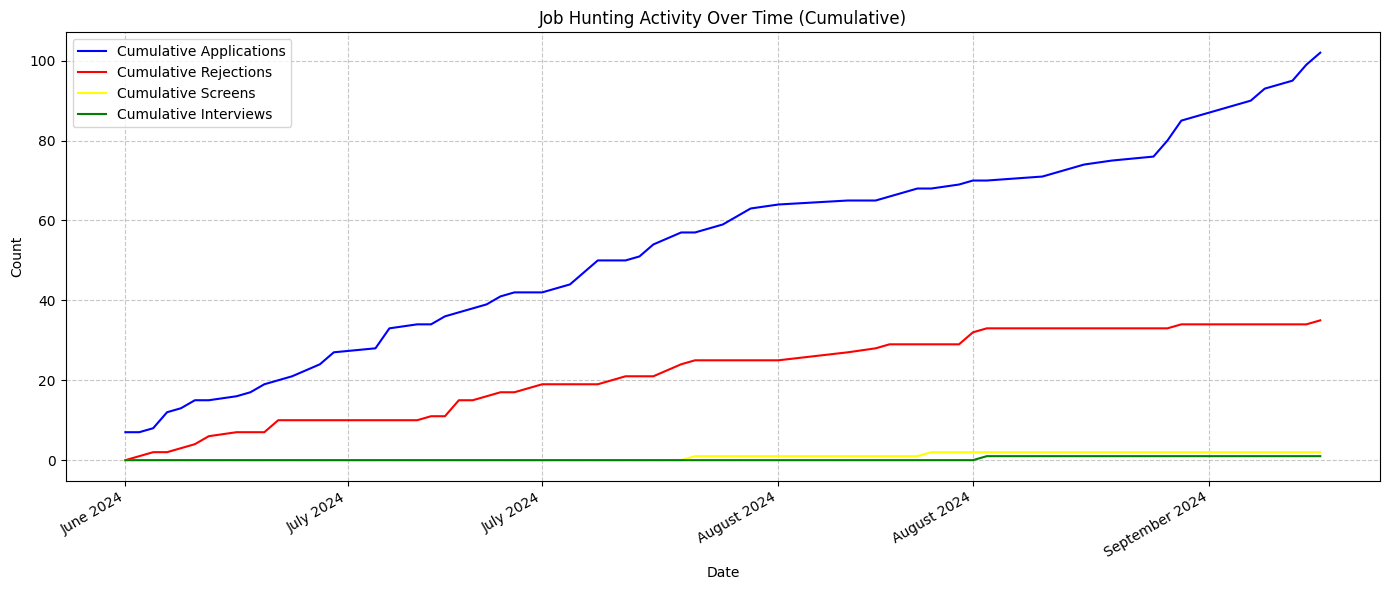

In [6]:

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(14, 6))  # Increased width to accommodate longer labels

# Plot the data
ax.plot(df.cumsum().index, df.cumsum()['total_applications'], label='Cumulative Applications', color='blue')
ax.plot(df.cumsum().index, df.cumsum()['total_rejections'], label='Cumulative Rejections', color='red')
ax.plot(df.cumsum().index, df.cumsum()['total_screens'], label='Cumulative Screens', color='yellow')
ax.plot(df.cumsum().index, df.cumsum()['total_interviews'], label='Cumulative Interviews', color='green')

# Customize the plot
ax.set_title('Job Hunting Activity Over Time (Cumulative)')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Format x-axis ticks
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%A, %B %d'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
# ax.xaxis.set_major_locator(mdates.DayLocator())

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Adjust layout to prevent cutting off labels
fig.tight_layout()

# Show the plot
plt.show()

In [7]:

# Check if the lru has built its is-qualified classifier
t1 = time.time()
if not (hasattr(lru, 'ISQUALIFIED_LR') and hasattr(lru, 'ISQUALIFIED_CV')):
    lru.build_isqualified_logistic_regression_elements(sampling_strategy_limit=None, verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
speech_str = f'Is-qualified LR elements built in {duration_str}'; print(speech_str)

I have 532,546 is-qualified vocabulary tokens in here
Is-qualified LR elements built in 6 seconds


I have 19,065 hand-labeled qualification strings in here
I have 532,831 is-qualified vocabulary tokens in here
Is-qualified classifer retrained in 1 minute and 57 seconds


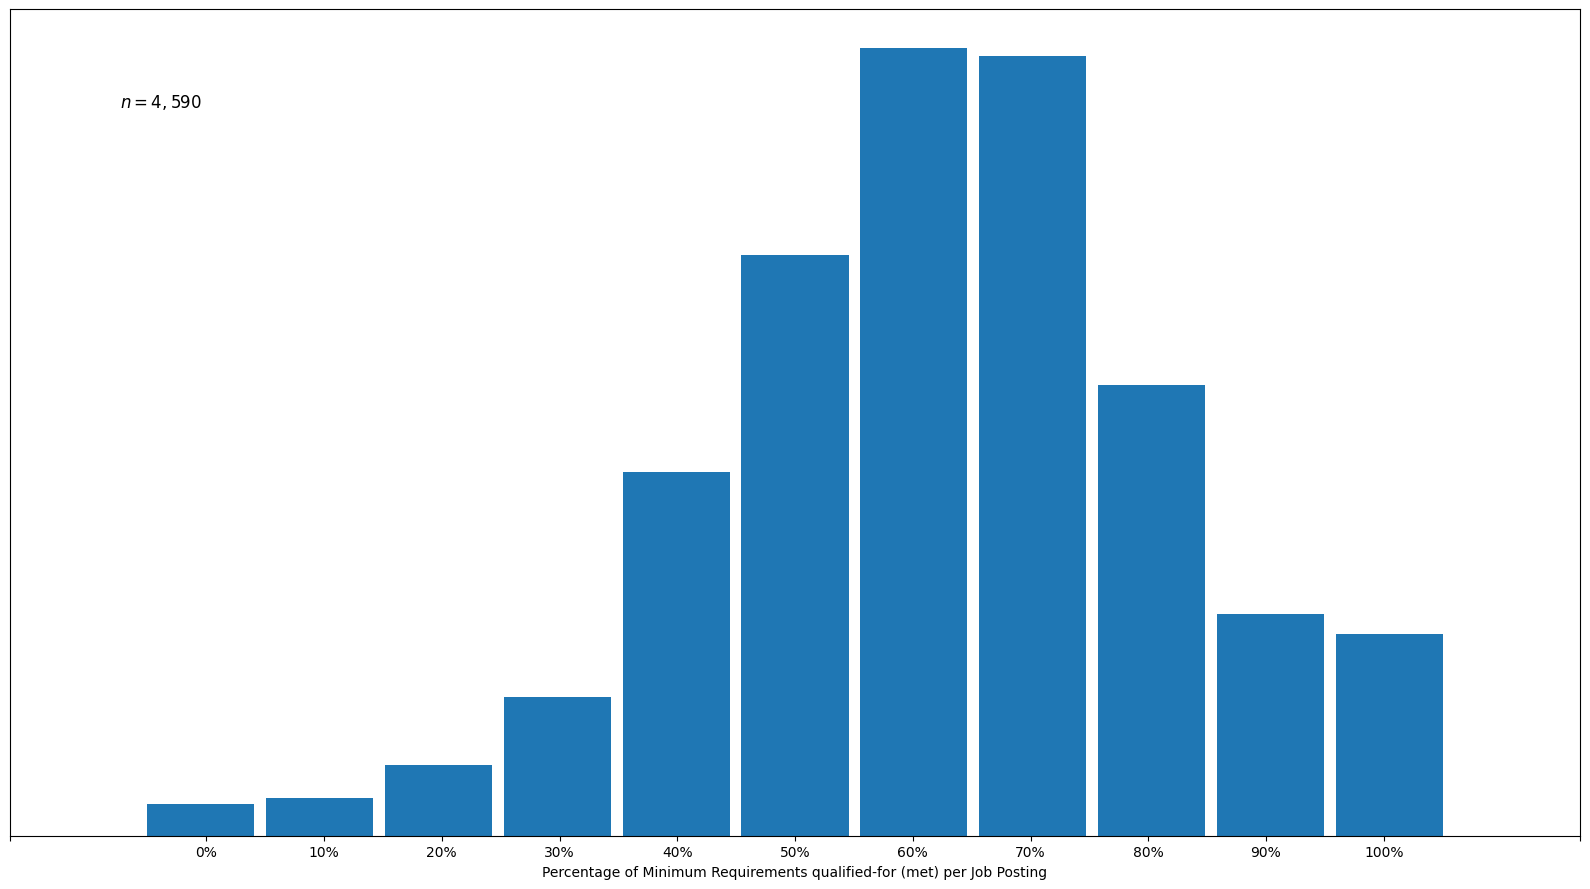

In [8]:

# You need to run this again if you changed the
# qualification dictionary below or in another notebook
t1 = time.time()

# Keep the total retraining time to less than two minutes by adjusting the sampling strategy limit
lru.sync_basic_quals_dict(sampling_strategy_limit=None, verbose=False)

lru.retrain_isqualified_classifier(verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
speech_str = f'Is-qualified classifer retrained in {duration_str}'; print(speech_str)
lru.display_hunting_dataframe_as_histogram(width_inches=16, height_inches=9)

In [9]:

cypher_str = '''
    MATCH (fn:FileNames)
    WHERE
        ((fn.tech_interview_completion_date <= date()) AND (fn.tech_interview_completion_date >= date("2024-06-13")))
        OR ((fn.recruiter_screen_completion_date <= date()) AND (fn.recruiter_screen_completion_date >= date("2024-06-13")))
        OR ((fn.rejection_email_date <= date()) AND (fn.rejection_email_date >= date("2024-06-13")))
        OR ((fn.opportunity_application_email_date <= date()) AND (fn.opportunity_application_email_date >= date("2024-06-13")))
    RETURN
        fn.file_name AS file_name,
        fn.is_closed AS is_closed,
        fn.is_opportunity_application_emailed AS is_opportunity_application_emailed,
        fn.is_recruiter_screen_completed AS is_recruiter_screen_completed,
        fn.is_tech_interview_completed AS is_tech_interview_completed,
        fn.is_verified AS is_verified,
        fn.opportunity_application_email_date AS opportunity_application_email_date,
        fn.percent_fit AS percent_fit,
        fn.posting_url AS posting_url,
        fn.recruiter_screen_completion_date AS recruiter_screen_completion_date,
        fn.rejection_email_date AS rejection_email_date,
        fn.rejection_email_text AS rejection_email_text,
        fn.tech_interview_completion_date AS tech_interview_completion_date;'''
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    applications_df = DataFrame(row_objs_list)
    mask_series = ~applications_df.opportunity_application_email_date.isnull()
    applications_df.loc[mask_series, 'week_number'] = applications_df.loc[mask_series, 'opportunity_application_email_date'].map(lambda x: x.isocalendar()[1])
    applications_df.loc[mask_series, 'year_number'] = applications_df.loc[mask_series, 'opportunity_application_email_date'].map(lambda x: x.year)
    display(applications_df.sample(3).T)

,97,28,83
file_name,8991e5d34c4ca70b_Junior_Quality_Assurance_Engi...,akqPCxf7SYrlFBkQ_l_oKg_Senior_Data_Scientist_R...,5YRW14BLcJWmPsBAHrXKsQ_Entry_Level_Research_Da...
is_closed,None,True,None
is_opportunity_application_emailed,True,True,True
is_recruiter_screen_completed,None,None,None
is_tech_interview_completed,None,None,None
is_verified,None,None,None
opportunity_application_email_date,2024-09-07,2024-07-12,2024-08-30
percent_fit,0.928571,1.0,0.8
posting_url,https://www.indeed.com/rc/clk/dl?jk=8991e5d34c...,https://www.linkedin.com/comm/jobs/view/397425...,https://www.linkedin.com/comm/jobs/view/401020...
recruiter_screen_completion_date,None,None,None


In [10]:

mask_series = ~applications_df.recruiter_screen_completion_date.isnull() | ~applications_df.tech_interview_completion_date.isnull()
display(applications_df[mask_series].sample(min(3, applications_df[mask_series].shape[0])).T)

,1,2,0
file_name,8fb605a1cad5b94f_Python_Developer_Informatics_...,hMAt6M1ae9pW73omZm4dhw_Senior_Machine_Learning...,a549539bc1bfd45d_Data_Analyst_Management_Data_...
is_closed,True,True,None
is_opportunity_application_emailed,True,True,True
is_recruiter_screen_completed,True,None,None
is_tech_interview_completed,None,None,True
is_verified,None,None,None
opportunity_application_email_date,2024-08-09,2024-06-27,2024-07-23
percent_fit,1.0,1.0,1.0
posting_url,https://www.indeed.com/rc/clk/dl?jk=8fb605a1ca...,https://www.linkedin.com/comm/jobs/view/391162...,https://www.indeed.com/rc/clk/dl?jk=a549539bc1...
recruiter_screen_completion_date,2024-08-12,2024-07-26,None


In [11]:

mask_series = ~applications_df.recruiter_screen_completion_date.isnull()
applications_df[mask_series].sort_values(['recruiter_screen_completion_date']).recruiter_screen_completion_date.tolist()

[neo4j.time.Date(2024, 7, 26), neo4j.time.Date(2024, 8, 12)]

In [12]:

mask_series = ~applications_df.tech_interview_completion_date.isnull()
applications_df[mask_series].sort_values(['tech_interview_completion_date']).tech_interview_completion_date.tolist()

[neo4j.time.Date(2024, 8, 16)]